### Import Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load The dataset

In [46]:
cars_df=pd.read_csv('cars.csv')

In [47]:
cars_df.head()

,Name,Price,Location,Model_Year,Mileage,Fuel_Type,Gearbox,Gearbox2
0,MG ZS EV LHD 45KWH LUXURY MY21,149900kr,"212 37 Malmö, Skåne",2020,1950 mil,Electric,≈ 263 km,Automatic
1,MG ZS EV 45KWH LUXURY *0% Räntekampanj,149900kr,"212 37 Malmö, Skåne",2021,4354 mil,Electric,≈ 263 km,Automatic
2,MG ZS EV 45KWH LUXURY *0% Räntekampanj,149900kr,"212 37 Malmö, Skåne",2021,2720 mil,Electric,≈ 263 km,Automatic
3,MG ZS EV 45kwh LUXUARY,149900kr,"212 37 Malmö, Skåne",2021,6833 mil,Electric,≈ 263 km,Automatic
4,Kia e-Niro ADVANCE 204 Hk 64 kWh Privatleasing...,259900kr,"141 74 Segeltorp, Stockholm",2021,4057 mil,Electric,≈ 455 km,Automatic


## 2. Data Cleaning

The dataset is quite messy, and the following steps will be performed systematically to clean and preprocess it:

1.Handle Missing Values:

Identify rows where the Model_Year (in formats like "Year" or "Month Year") is missing.
Remove these rows from the dataset, as the Model_Year is a critical feature.

2.Fix Misaligned Rows:

Address misalignment issues observed in the Model_Year column, where values like '1 / 1', '1 / 2', and '1 / 3' were incorrectly assigned.
Shift such misaligned values to their correct columns.

3.Gearbox Column Issues:

Drop rows where the Gearbox column does not have valid values, i.e., Automatic or Manual.
Remove the Gearbox2 column, as it is redundant and no longer needed.

4.Feature Extraction:

Extract the brand name from the Name column into a new column, Brand.
Extract the model name from the Name column into a new column, Model.

5.Location Cleaning:

Extract only the city name from the Location column into a new column, City.

6.Price Column Cleaning:

Remove the 'kr' suffix from the Price column and convert it to an integer data type.

7.Model_Year Column Cleaning:

Extract only the year value from the Model_Year column, discarding additional information like month names.

8.Combine Brand and Model:

Create a combined column, Brand_Model, to analyze the popularity of specific car models.

9.Mileage Column Cleaning:

Remove rows where the Mileage column contains values like Electric, which are not valid mileage values.
Remove the ' mil' suffix from mileage values and convert the column to an integer data type.

10.Remove Unnecessary Columns:

Drop columns that are irrelevant or redundant after the cleaning process.

11.Data Type Conversion:

Ensure all columns have the appropriate data types (e.g., numeric for mileage, price, and year).

### Automating the data cleaning section

In [48]:
def fix_gear(row):
    if 'km' in str(row['Gearbox']):
        row['Gearbox'] = row['Gearbox2']  # Assign 'Gearbox2' to 'Gearbox'
        row['Gearbox2'] = None  # Clear 'Gearbox2' as it is no longer needed
    return row

def correct_data_types(df):
    df['Price'] = df['Price'].replace('kr', '', regex=True).astype(int)
    
    # Convert to string and remove any non-numeric characters
    df['Mileage'] = df['Mileage'].astype(str).str.replace(r'\D', '', regex=True)
    df['Mileage'] = df['Mileage'].replace('', np.nan).astype(float).astype('Int64')
    
    # Extract year and handle NaN values before conversion
    df['Year'] = df['Model_Year'].str.extract(r'(\b\d{4}\b)').astype(float)
    df['Year'] = df['Year'].fillna(0).astype(int)
    
    return df

def clean_data(df):
    # Apply the fix_gear function
    df = df.apply(fix_gear, axis=1)
    
    # Drop rows where Gearbox is not either 'Automatic' or 'Manual'
    df = df[df['Gearbox'].isin(['Manual', 'Automatic'])]
    
    # Drop Gearbox2 as it is no longer needed
    df = df.drop('Gearbox2', axis=1)
    
    # Check Mileage and drop invalid rows
    df = df[df['Mileage'] != 'Electric'].reset_index(drop=True)
    
    # Correct data types
    df = correct_data_types(df)

    # Rename Gearbox column
    df.rename(columns={'Gearbox':'Transmission'},inplace= True)
    
    return df

# Apply the complete cleaning process
cars_df = clean_data(cars_df)

In [51]:
# Feature ENgineering
cars_df['Price_per_Mile'] = cars_df['Price'] / cars_df['Mileage']
cars_df['Price_per_Mile'] =cars_df['Price'] / cars_df['Mileage']
cars_df['Brand']=cars_df['Name'].str.split(' ').str[0]
cars_df['Brand_Model'] = cars_df['Name'].str.split().str[:2].str.join(' ')

In [54]:
def categorize_fuel_type(fuel_type):
    if 'Electric' in fuel_type and '/' not in fuel_type:
        return 'Electric'
    elif 'Hybrid' in fuel_type or 'Electric/' in fuel_type:
        return 'Hybrid'
    elif 'Petrol' in fuel_type and 'Electric/' not in fuel_type:
        return 'Petrol'
    elif 'Diesel' in fuel_type and 'Electric/' not in fuel_type:
        return 'Diesel'
    elif 'Natural gas' in fuel_type:
        return 'Natural Gas'
    else:
        return 'Ethanol'
    

# Apply the categorization to the Fuel_Type column
cars_df['Fuel'] = cars_df['Fuel_Type'].apply(categorize_fuel_type)

print(cars_df['Fuel'].value_counts())

Fuel
Petrol         864
Diesel         742
Electric       606
Hybrid         424
Ethanol         13
Natural Gas      4
Name: count, dtype: int64


In [55]:
# Define a function to extract the city name
def extract_city(location):
    if 'Delivered to you' in location:
        return None  # Mark rows with 'Delivered to you' for deletion
    elif ',' in location:
        return location.split(',')[1].strip()  # Extract county after comma
    else:
        return location.strip()  # If no comma, return the full location as county

# Apply the function to the Location column
cars_df['County'] = cars_df['Location'].apply(extract_city)

# Drop rows where County is None
cars_df = cars_df.dropna(subset=['County'])


In [56]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Feature Engineering
df = cars_df[['Brand', 'Mileage', 'Fuel', 'Transmission', 'Year', 'County', 'Price_per_Mile', 'Price']]

# One-Hot Encoding for categorical variables
dummies = pd.get_dummies(df[['Brand', 'Fuel', 'Transmission', 'County']], drop_first=True, dtype='int')
df = df.drop(['Brand', 'Fuel', 'Transmission', 'County'], axis=1)
df = pd.concat([df, dummies], axis=1)

# Define feature matrix X and target variable y
X = df.drop('Price', axis=1)
y = df['Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Standardize the feature matrix
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert back to DataFrame for better readability
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=101),
    "Decision Tree": DecisionTreeRegressor(random_state=101),
    "Support Vector Regressor": SVR()
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R2 Score": r2}

# Display the results
print("\nModel Performance:")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['RMSE']:.2f}, R2 Score = {metrics['R2 Score']:.2f}")

# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\nPerforming Grid Search for Random Forest...")
grid_search = GridSearchCV(RandomForestRegressor(random_state=101), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate the optimized Random Forest model
y_pred_best_rf = best_rf.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\nOptimized Random Forest Performance:")
print(f"RMSE = {rmse_best_rf:.2f}, R2 Score = {r2_best_rf:.2f}")

Training Linear Regression...
Training Random Forest...
Training Decision Tree...
Training Support Vector Regressor...

Model Performance:
Linear Regression: RMSE = 139101.81, R2 Score = 0.58
Random Forest: RMSE = 44494.39, R2 Score = 0.96
Decision Tree: RMSE = 108926.98, R2 Score = 0.74
Support Vector Regressor: RMSE = 218561.98, R2 Score = -0.05

Performing Grid Search for Random Forest...
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Optimized Random Forest Performance:
RMSE = 42251.77, R2 Score = 0.96


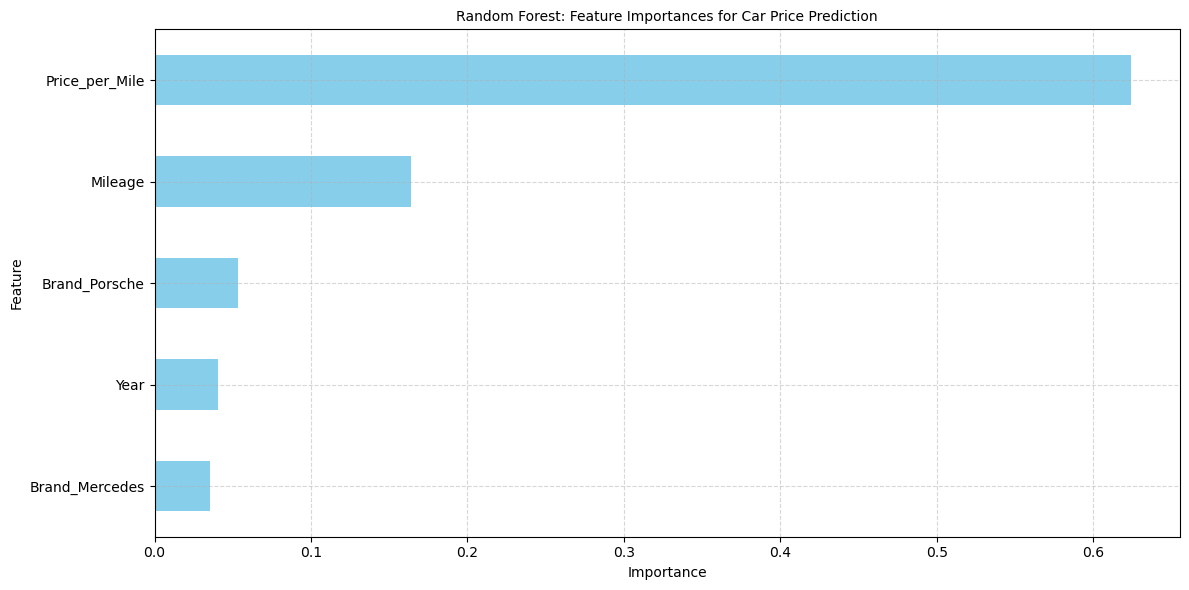

In [58]:
# Create a Pandas Series to store feature importances from the model
feature_rank=pd.Series(best_rf.feature_importances_,index=X_train.columns,name='Importance').sort_values(ascending=True,inplace=False)[-5:]

# Plotting a horizontal bar chart to visualize feature importances
ax=feature_rank.plot(kind='barh',figsize=(12,6), color='skyblue')

# Setting x-axis and y-axis labels, and the title for the plot 
plt.xlabel("Importance", fontsize=10)
plt.ylabel("Feature", fontsize=10)
plt.title("Random Forest: Feature Importances for Car Price Prediction", fontsize=10)

#add line grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show();

SAve the model

In [60]:
import joblib

joblib.dump(best_rf, 'rf.pkl')

['rf.pkl']

In [61]:
# Load the saved model
import joblib
loaded_model = joblib.load('rf.pkl')

In [62]:
# Predict prices using the test set
predictions=loaded_model.predict(X_test)

In [64]:
# Create a DataFrame with actual, predicted, and price difference
undervalued_df = pd.DataFrame({
    'Actual': y_test,
    'Predictions': predictions
})

# Calculate the price difference
undervalued_df['Price_Difference'] = undervalued_df['Predictions'] - undervalued_df['Actual']

# Identify undervalued cars with a threshold of 10%, select those cars with a price difference that is higher than 10% of the the car's true price.
threshold = 0.1
undervalued_mask = undervalued_df['Price_Difference'] > (threshold * undervalued_df['Actual'])

# Filter undervalued cars early
undervalued_df = undervalued_df[undervalued_mask]

# Add 'Brand' and 'Brand_Model' details from the original dataset so that we can see which Brand and Model
undervalued_with_details = undervalued_df.join(cars_df[['Brand', 'Brand_Model']], how='left')
undervalued_with_details

,Actual,Predictions,Price_Difference,Brand,Brand_Model
849,254700,3.123876e+05,57687.584167,MG,MG MG5
1123,279900,3.227472e+05,42847.200637,Mercedes,Mercedes Vito
1604,599900,6.726558e+05,72755.837143,Volvo,Volvo S90
479,259900,3.086137e+05,48713.700000,MG,MG MG4
899,389000,6.020396e+05,213039.644405,Kia,Kia e-Niro
1544,364800,5.163747e+05,151574.661905,Kia,Kia e-Niro
1023,394900,4.428509e+05,47950.932857,Kia,Kia Sportage
628,919000,1.171812e+06,252811.630159,Porsche,Porsche Cayenne
1845,92000,1.130348e+05,21034.775108,Renault,Renault Kangoo
376,358000,4.880019e+05,130001.879881,Volvo,Volvo EX30


In [65]:
len(undervalued_with_details)

40

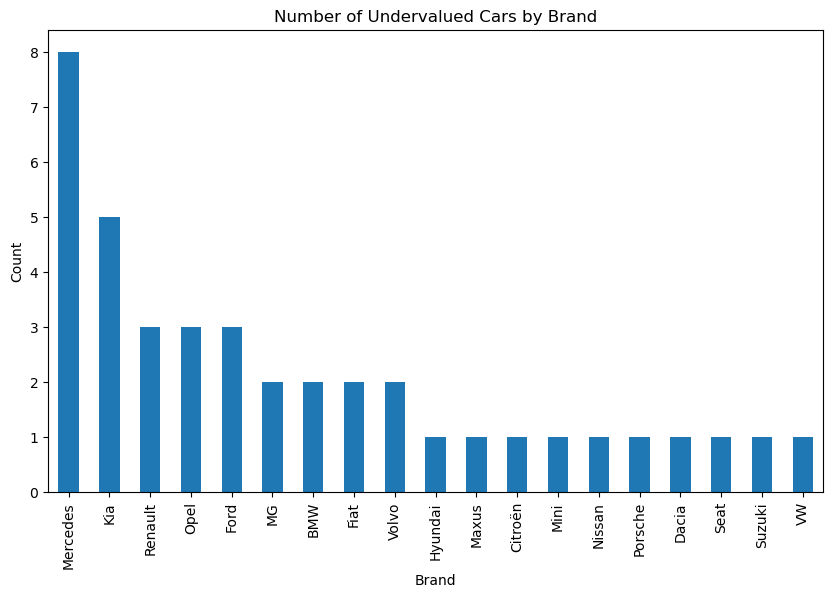

In [66]:
# Plot undervalued cars by brand
undervalued_with_details.groupby('Brand').size().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Number of Undervalued Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()